In [1]:
Alpha_Name = "5_Input_20220110_10d_ret_StandardScale_MinMax_10"
start_date = "2020-01-01"
end_date = "2020-06-01"

In [12]:
import time
import os
from Research.backtest.bt import BTDaily
import matplotlib.pyplot as plt
from Research.feature.ft import FeatureAnalysis
import Research.utils.namespace as namespace
import Research.utils.normalization as norm
from Platform.database.mysql import MysqlAPI
from Platform.utils.persistence import convert_to_standard_daily_feature_csv, convert_to_standard_daily_feature_par
from Platform.config.mysql_info import FACTOR_LIB_MYSQL_TIO
import DataAPI
from os import walk
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from progressbar import ProgressBar
from tqdm import tqdm
import multiprocessing as mp
import sys
sys.path.append("/home/wuwenjun/jupyter_code/Shannon/AlphaNet/packages/")
model_path = "/home/wuwenjun/Alpha_Factor/" + Alpha_Name + "/" + "%s_%s" %(start_date,end_date) + "/"
if os.path.exists(model_path) == False:
    os.makedirs(model_path)
    print(model_path)

In [3]:
from AlphaNet.Data import DataLoader
trainloader = DataLoader()
trainloader.load_data_from_file(alpha_name = Alpha_Name,end_date = start_date)

  3%|▎         | 34/1219 [00:00<00:04, 260.88it/s]

Loading the configuration from /home/ShareFolder/lgc/Modules/Research/config/feature_bt_template
Loading the configuration from /home/ShareFolder/lgc/Modules/Research/config/feature_bt_template


100%|██████████| 1219/1219 [00:43<00:00, 27.77it/s]


0         1            2         3  \
timestamp           ticker                                              
2015-02-16 09:30:00 000001  0.000064 -0.038558  3954.352065 -0.014480   
                    000002  0.000147  0.135621  5523.931352 -0.033847   
                    000004  0.000093 -0.003361   -18.869629 -0.019579   
                    000005  0.000000  0.000000     0.000000  0.000000   
                    000006  0.000035  0.054798  2741.562408 -0.009933   
...                              ...       ...          ...       ...   
2019-12-31 09:30:00 688366  0.000073 -0.002688    22.559362 -0.016287   
                    688368  0.000197 -0.010143   -26.907990 -0.032727   
                    688369  0.000015 -0.008861    84.007717 -0.032206   
                    688388  0.000037 -0.001228    78.998641 -0.007192   
                    688389  0.000027 -0.002629     6.048070 -0.015823   

                                   4             5         6             7  \
timestamp           ticker                                                   
2015-02-16 09:30:00 000001 -0.153531  -2626.705689 -0.017612  1.415203e+07   
                    000002 -0.583065 -11505.304621 -0.048414  8.801691e+07   
                    000004 -0.011733   -121.588925 -0.039625  6.284071e+03   
                    000005  0.000000      0.000000  0.000000  0.000000e+00   
                    000006  0.008375    430.094542 -0.002161  1.746874e+06   
...                              ...           ...       ...           ...   
2019-12-31 09:30:00 688366 -0.021921    -70.007276 -0.041304  7.920580e+03   
                    688368 -0.012189    -57.497162 -0.052928  2.288874e+03   
                    688369 -0.008649    -19.593120 -0.012468  6.057487e+03   
                    688388 -0.003517    -91.809291 -0.025993  3.661133e+03   
                    688389 -0.000241     -2.246640 -0.004988  3.053870e+03   

                                     8             9  ...       111       112  \
timestamp           ticker                            ...                       
2015-02-16 09:30:00 000001   13.814661  1.150742e+05  ...  0.345175  0.023481   
                    000002  121.464693  2.913541e+06  ...  0.085346 -0.009313   
                    000004    1.512995  1.306707e+04  ...  0.081493  0.038451   
                    000005    0.000000  0.000000e+00  ... -1.000000  0.000000   
                    000006    0.897457 -3.758064e+04  ...  0.088571  0.000000   
...                                ...           ...  ...       ...       ...   
2019-12-31 09:30:00 688366    2.309137  1.129469e+04  ... -0.150452 -0.035167   
                    688368    2.688252  7.848888e+03  ...  1.141902  0.113985   
                    688369    0.313709 -3.432590e+03  ...  0.344850 -0.018097   
                    688388    1.455787  1.702078e+04  ...  4.525981  0.209164   
                    688389    0.238123  2.053975e+03  ...  0.125396  0.011139   

                                 113        114       115       116  \
timestamp           ticker                                            
2015-02-16 09:30:00 000001  0.031142  -1.301542  0.014472 -0.012360   
                    000002 -0.004410  -2.271306  0.020087 -0.022228   
                    000004 -0.009981  -1.736879  0.011924 -0.014008   
                    000005 -1.000000  -1.000000  0.000000  0.000000   
                    000006  0.060849  -2.261014  0.013070 -0.012106   
...                              ...        ...       ...       ...   
2019-12-31 09:30:00 688366 -0.119583   2.143160  0.016155 -0.008964   
                    688368 -0.023913   1.428267  0.034565 -0.034247   
                    688369 -0.242743 -16.035785  0.019045 -0.011697   
                    688388  0.212289   4.499188  0.026055 -0.035712   
                    688389 -0.359154  -1.307557  0.018120 -0.016364   

                                    117           118       119    target  
timestamp       

In [4]:
train_loader = trainloader.to_torch_DataLoader(sequence = 3,shuffle=True)

In [7]:
from AlphaNet.Models import AlphaNet_LSTM_V1
from AlphaNet import Model_Loader
import torch.optim as optim
LR = 0.001
epoch_num = 10
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
loss_function = nn.MSELoss()
model = AlphaNet_LSTM_V1(40, 30)
optimizer = optim.Adam(model.parameters(), lr=LR)
model_loader = Model_Loader(model = model,device=device)
print(model_loader.model)

AlphaNet_LSTM_V1(
  (batch): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(40, 30, num_layers=2, batch_first=True, bidirectional=True)
  (batch2): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=30, out_features=1, bias=True)
)


  0%|          | 0/30 [00:00<?, ?it/s]

Learning Rate is : 0.001


  3%|▎         | 1/30 [00:54<26:30, 54.84s/it]

Epoch:  1  loss:  5.13190262488555


  7%|▋         | 2/30 [01:36<22:05, 47.35s/it]

Epoch:  2  loss:  3.341018400831666


 10%|█         | 3/30 [02:08<17:58, 39.94s/it]

Epoch:  3  loss:  3.0836608650787145


 13%|█▎        | 4/30 [02:41<16:14, 37.48s/it]

Epoch:  4  loss:  2.940718219603881


 17%|█▋        | 5/30 [03:12<14:34, 34.98s/it]

Epoch:  5  loss:  2.8721029675953327


 20%|██        | 6/30 [03:51<14:31, 36.31s/it]

Epoch:  6  loss:  2.8314357240877093


 23%|██▎       | 7/30 [04:26<13:47, 36.00s/it]

Epoch:  7  loss:  2.8012586893292544


 27%|██▋       | 8/30 [05:02<13:09, 35.90s/it]

Epoch:  8  loss:  2.7785226056043175


 30%|███       | 9/30 [05:41<12:56, 36.98s/it]

Epoch:  9  loss:  2.7585282328249314


 33%|███▎      | 10/30 [06:11<11:38, 34.91s/it]

Epoch:  10  loss:  2.7430300224127016


 37%|███▋      | 11/30 [06:45<10:54, 34.46s/it]

Epoch:  11  loss:  2.7279984041353282


 40%|████      | 12/30 [07:17<10:07, 33.75s/it]

Epoch:  12  loss:  2.713905664771279


 43%|████▎     | 13/30 [07:54<09:52, 34.85s/it]

Epoch:  13  loss:  2.703827799322415


 47%|████▋     | 14/30 [08:36<09:49, 36.87s/it]

Epoch:  14  loss:  2.693721183660156


 50%|█████     | 15/30 [09:09<08:58, 35.88s/it]

Epoch:  15  loss:  2.685127513369474


 53%|█████▎    | 16/30 [09:42<08:06, 34.74s/it]

Epoch:  16  loss:  2.6770220685374144


 57%|█████▋    | 17/30 [10:26<08:08, 37.58s/it]

Epoch:  17  loss:  2.66950384168661


 60%|██████    | 18/30 [11:08<07:47, 38.92s/it]

Epoch:  18  loss:  2.6630976405051907


 63%|██████▎   | 19/30 [11:41<06:50, 37.32s/it]

Epoch:  19  loss:  2.6571465163755192


 67%|██████▋   | 20/30 [12:17<06:06, 36.67s/it]

Epoch:  20  loss:  2.652456511287994


 70%|███████   | 21/30 [12:52<05:25, 36.17s/it]

Epoch:  21  loss:  2.645943761309076


 73%|███████▎  | 22/30 [13:33<05:03, 37.88s/it]

Epoch:  22  loss:  2.6412923468120315


 77%|███████▋  | 23/30 [14:06<04:14, 36.33s/it]

Epoch:  23  loss:  2.636598476266332


 80%|████████  | 24/30 [14:46<03:45, 37.54s/it]

Epoch:  24  loss:  2.633230588107919


 83%|████████▎ | 25/30 [15:19<03:00, 36.09s/it]

Epoch:  25  loss:  2.628510515937546


 87%|████████▋ | 26/30 [16:00<02:30, 37.52s/it]

Epoch:  26  loss:  2.623200359620455


 90%|█████████ | 27/30 [16:49<02:02, 40.82s/it]

Epoch:  27  loss:  2.6199834368847372


 93%|█████████▎| 28/30 [17:30<01:21, 40.98s/it]

Epoch:  28  loss:  2.616557171329821


 97%|█████████▋| 29/30 [18:18<00:42, 42.97s/it]

Epoch:  29  loss:  2.6131766690463922


100%|██████████| 30/30 [18:52<00:00, 37.74s/it]

Epoch:  30  loss:  2.609786171745685


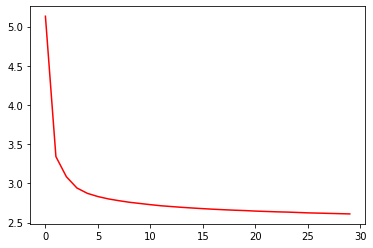

In [9]:
model = model_loader.fit_transform(train_loader,optimizer,loss_function,epoch_num,save_path = model_path)

  0%|          | 0/20 [00:00<?, ?it/s]

Learning Rate is : 0.0001


  5%|▌         | 1/20 [00:42<13:19, 42.07s/it]

Epoch:  1  loss:  2.58033055818527


 10%|█         | 2/20 [01:17<11:27, 38.22s/it]

Epoch:  2  loss:  2.576102166229978


 15%|█▌        | 3/20 [01:54<10:36, 37.46s/it]

Epoch:  3  loss:  2.57465994213742


 20%|██        | 4/20 [02:32<10:02, 37.65s/it]

Epoch:  4  loss:  2.574146216900009


 25%|██▌       | 5/20 [03:06<09:08, 36.54s/it]

Epoch:  5  loss:  2.573258924913315


 30%|███       | 6/20 [03:48<08:56, 38.30s/it]

Epoch:  6  loss:  2.572625077302475


 35%|███▌      | 7/20 [04:42<09:25, 43.51s/it]

Epoch:  7  loss:  2.570529071516679


 40%|████      | 8/20 [05:25<08:41, 43.44s/it]

Epoch:  8  loss:  2.5701565097196357


 45%|████▌     | 9/20 [06:03<07:38, 41.65s/it]

Epoch:  9  loss:  2.571030636130976


 50%|█████     | 10/20 [06:51<07:14, 43.43s/it]

Epoch:  10  loss:  2.5693483442804603


 55%|█████▌    | 11/20 [07:42<06:53, 45.94s/it]

Epoch:  11  loss:  2.569442974496171


 60%|██████    | 12/20 [08:31<06:13, 46.69s/it]

Epoch:  12  loss:  2.568098031626223


 65%|██████▌   | 13/20 [09:17<05:25, 46.47s/it]

Epoch:  13  loss:  2.5686006741556624


 70%|███████   | 14/20 [10:05<04:42, 47.01s/it]

Epoch:  14  loss:  2.5674391974208


 75%|███████▌  | 15/20 [11:00<04:06, 49.39s/it]

Epoch:  15  loss:  2.5672514865426406


 80%|████████  | 16/20 [11:53<03:21, 50.42s/it]

Epoch:  16  loss:  2.5670348952819237


 85%|████████▌ | 17/20 [12:44<02:32, 50.75s/it]

Epoch:  17  loss:  2.5668515607630393


 90%|█████████ | 18/20 [13:36<01:42, 51.15s/it]

Epoch:  18  loss:  2.5661979252207017


 95%|█████████▌| 19/20 [14:29<00:51, 51.80s/it]

Epoch:  19  loss:  2.565480605637538


100%|██████████| 20/20 [15:25<00:00, 46.27s/it]

Epoch:  20  loss:  2.5656297005216495


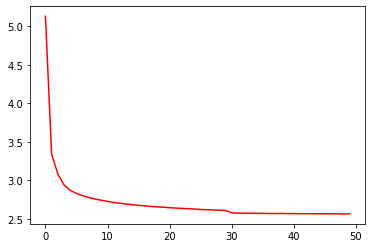

In [26]:
optimizer = optim.Adam(model.parameters(), lr=LR/10)
model = model_loader.transform(optimizer = optimizer, epoch_num = 20, method="best")

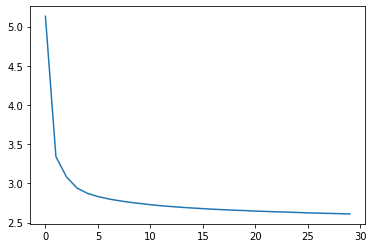

In [13]:
plt.plot(model_loader.loss_list)

In [27]:
testloader = DataLoader()
testloader.load_data_from_file(alpha_name = Alpha_Name,start_date = start_date,end_date = end_date)
test_loader = testloader.to_torch_DataLoader(sequence = 3,shuffle=False)
pred = model_loader.pred(test_loader)

100%|██████████| 98/98 [00:03<00:00, 27.26it/s]


In [28]:
final = pd.concat([testloader.target.reset_index(),pred],axis=1)
final.rename(columns={0:Alpha_Name,'ticker': 'symbol'},inplace=True)
final

,timestamp,symbol,target,5_Input_20220110_10d_ret_StandardScale_MinMax_10
0,2020-01-02 09:30:00,000001,-5.551395,-4.294944
1,2020-01-02 09:30:00,000002,-6.203258,-6.654584
2,2020-01-02 09:30:00,000004,-5.390784,-7.166056
3,2020-01-02 09:30:00,000005,-5.142255,-3.337142
4,2020-01-02 09:30:00,000006,-5.327572,-6.606823
...,...,...,...,...
369026,2020-06-01 09:30:00,688388,-4.510971,-5.490549
369027,2020-06-01 09:30:00,688389,-3.960987,-6.050290
369028,2020-06-01 09:30:00,688396,-4.365947,-5.212210
369029,2020-06-01 09:30:00,688398,-4.135321,-8.062607


In [29]:
final.to_parquet(model_path + "result.par")